<a href="https://colab.research.google.com/github/olumideaeo/Machine-Learning-Collection/blob/master/kanglishbest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Train_Kanglish.csv')
raw.tail()

,word,tag
14842,hiremadtara,en-kn
14843,solutionila,en-kn
14844,accessmadkoli,en-kn
14845,glasshakisi,en-kn
14846,keybeku,en-kn


In [ ]:

seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

In [ ]:
x_train_full = raw['word']
y_train_full = raw['tag']


Example:
LANG = kn
TEXT = anusthu


In [ ]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [ ]:
char_vocab = Dictionary()
pad_token = '<pad>' 
unk_token = '<unk>'
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)


chars = set(''.join(x_train_full))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

lang_vocab = Dictionary()

languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "tags")

Vocabulary: 164 UTF characters
Labels: 6 tags


In [ ]:

x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx,test_size=0.005, random_state=0)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

14772 training samples
75 validation samples


In [ ]:
def batch_generator(data, batch_size, token_size):
   
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [ ]:
def pool_generator(data, batch_size, token_size, shuffle=False):

    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [ ]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        encoded = self.embed(input)
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        output, _ = self.rnn(packed)
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        output, _ = padded.max(dim=0)
        output = self.h2o(output)
        return output

In [ ]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [ ]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)      
        optimizer.step()
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
        total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [ ]:
def validate(model, data, batch_size, token_size):
    model.eval()
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
            dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [ ]:
hidden_size = 256
embedding_size = 256
bidirectional = False
ntokens = len(char_vocab)
nlabels = len(lang_vocab)

In [ ]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [ ]:
batch_size, token_size = 128, 200000
epochs =30
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
for epoch in range(1, epochs + 1):
    tr_acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(tr_acc)
    print(f'| epoch {epoch:03d} | train accuracy={tr_acc:.1f}% ')
    vl_acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(vl_acc)
    print(f'| epoch {epoch:03d} | valid accuracy={vl_acc:.1f}%')

Training cross-validation model for 30 epochs
Train: wpb=905, bsz=127, num_updates=116
| epoch 001 | train accuracy=60.9% 
| epoch 001 | valid accuracy=70.7%
| epoch 002 | train accuracy=72.2% 
| epoch 002 | valid accuracy=74.7%
| epoch 003 | train accuracy=75.8% 
| epoch 003 | valid accuracy=80.0%
| epoch 004 | train accuracy=78.1% 
| epoch 004 | valid accuracy=81.3%
| epoch 005 | train accuracy=80.0% 
| epoch 005 | valid accuracy=80.0%
| epoch 006 | train accuracy=81.7% 
| epoch 006 | valid accuracy=80.0%
| epoch 007 | train accuracy=83.4% 
| epoch 007 | valid accuracy=80.0%
| epoch 008 | train accuracy=84.1% 
| epoch 008 | valid accuracy=80.0%
| epoch 009 | train accuracy=85.3% 
| epoch 009 | valid accuracy=76.0%
| epoch 010 | train accuracy=87.0% 
| epoch 010 | valid accuracy=82.7%
| epoch 011 | train accuracy=87.6% 
| epoch 011 | valid accuracy=78.7%
| epoch 012 | train accuracy=89.2% 
| epoch 012 | valid accuracy=84.0%
| epoch 013 | train accuracy=89.8% 
| epoch 013 | valid accur

In [ ]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

CharRNNClassifier(
  (embed): Embedding(164, 256, padding_idx=0)
  (rnn): LSTM(256, 256)
  (h2o): Linear(in_features=256, out_features=6, bias=True)
)
embed.weight         41984 [164, 256]
rnn.weight_ih_l0     262144 [1024, 256]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
h2o.weight           1536 [6, 256]
h2o.bias             6 [6]
TOTAL                569862


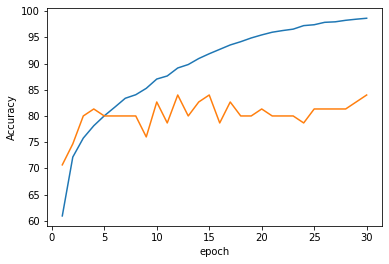

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

In [ ]:
tr_acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
train_accuracy.append(tr_acc)
print(f'| epoch {epoch:03d} | train accuracy={tr_acc:.1f}%)')
vl_acc = validate(model, val_data, batch_size, token_size)
valid_accuracy.append(vl_acc)
print(f'| epoch {epoch:03d} | valid accuracy={vl_acc:.1f}%')

| epoch 030 | train accuracy=98.7%)
| epoch 030 | valid accuracy=85.3%
